In [16]:
import mxnet as mx
import numpy as np
import gluoncv as gcv
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from mxnet import nd, image, autograd, gluon
from mxnet.gluon.data.vision import transforms
from gluoncv.model_zoo import get_model
from gluoncv.utils import viz, download

In [3]:
plt.rcParams['figure.figsize'] = (15, 9)

# Object Detection with Gluon CV

Build a state-of-the-art Single Shot Multibox Detection Network trained on the Pascal VOC dataset

## Dataset for Object Detection

![](support/pascal.png)



Pascal VOC is a collection of datasets for object detection. The most commonly combination for benchmarking is using 2007 trainval and 2012 trainval for training and 2007 test for validation.

In [4]:
from gluoncv.data import VOCDetection

train_dataset = VOCDetection(splits=[(2007, 'trainval'), (2012, 'trainval')])
val_dataset = VOCDetection(splits=[(2007, 'test')])

print('Training images:', len(train_dataset))
print('Validation images:', len(val_dataset))

Training images: 16551
Validation images: 4952


Let's see what a training example looks like

In [5]:
train_image, train_label = train_dataset[2]
bboxes = train_label[:, :4]
cids = train_label[:, 4]
print('image:', train_image.shape)
print('bboxes:', bboxes.shape, 'class ids:', cids.shape)

image: (375, 500, 3)
bboxes: (4, 4) class ids: (4,)


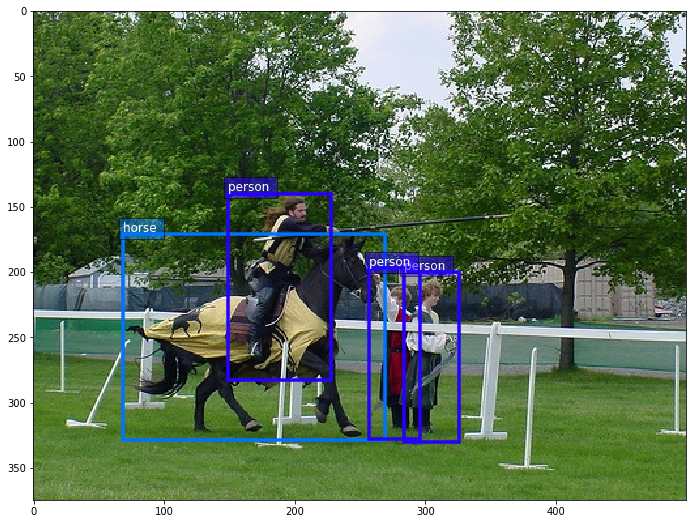

In [6]:
ax = viz.plot_bbox(train_image.asnumpy(),
                   bboxes,
                   labels=cids,
                   class_names=train_dataset.classes)
plt.show()

### Data Transformations

In [7]:
from gluoncv.data.transforms import presets

width, height = 512, 512  # we use 512 as base training size
train_transform = presets.ssd.SSDDefaultTrainTransform(width, height)
val_transform = presets.ssd.SSDDefaultValTransform(width, height)

Let's visualize the transformations

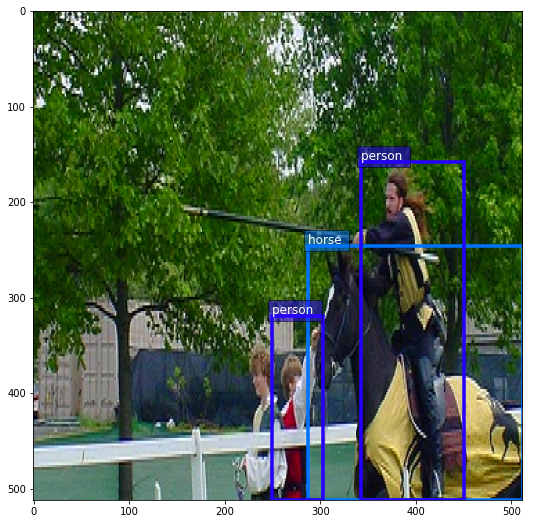

In [8]:
def repixelize(image):
    return ((image.transpose((1, 2, 0)) * nd.array((0.229, 0.224, 0.225)) + nd.array((0.485, 0.456, 0.406))) * 255).clip(0, 255)

transformed_train_image, transformed_train_label = train_transform(train_image, train_label)
ax = viz.plot_bbox(repixelize(transformed_train_image).asnumpy(), 
                   transformed_train_label[:, :4],
                   labels=transformed_train_label[:, 4],
                   class_names=train_dataset.classes)
plt.show()

Transforms used in training include random expanding, random cropping, color distortion, random flipping, etc. In comparison, validation transforms are simpler and only resizing and color normalization is used.

## DataLoader

Because the number of objects varys a lot across images, we also have varying label sizes. As a result, we need to pad those labels to the same size. To deal with this problem, GluonCV provides `gluoncv.data.batchify.Pad`, which handles padding automatically. `gluoncv.data.batchify.Stack` in addition, is used to stack NDArrays with consistent shapes. `gluoncv.data.batchify.Tuple` is used to handle different behaviors across multiple outputs from transform functions.

In [9]:
from gluoncv.data.batchify import Tuple, Stack, Pad
from mxnet.gluon.data import DataLoader

batch_size = 32
num_workers = 4

batchify_fn = Tuple(Stack(), Pad(pad_val=-1))

train_dataloader = DataLoader(train_dataset.transform(train_transform),
                          batch_size,
                          shuffle=True,
                          batchify_fn=batchify_fn,
                          last_batch='rollover',
                          num_workers=num_workers)
val_dataloader = DataLoader(val_dataset.transform(val_transform),
                        batch_size,
                        shuffle=False,
                        batchify_fn=batchify_fn,
                        last_batch='keep',
                        num_workers=num_workers)

## Model for Object Detection
![](support/ssd.png)
![](https://i.stack.imgur.com/Z3cIS.png)

In [10]:
from gluoncv import model_zoo
net = model_zoo.get_model('ssd_512_mobilenet1.0_voc', pretrained_base=False)
print(net)

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/gluon/block.py:1146: UserWarning: Cannot decide type for the following arguments. Consider providing them as input:
	data: None
  input_sym_arg_type = in_param.infer_type()[0]


SSD(
  (features): FeatureExpander(
  <Symbol group [ssd0_mobilenet0_relu22_fwd, ssd0_mobilenet0_relu26_fwd, ssd0_expand_reu0, ssd0_expand_reu1, ssd0_expand_reu2, ssd0_expand_reu3]> : 1 -> 6
  )
  (class_predictors): HybridSequential(
    (0): ConvPredictor(
      (predictor): Conv2D(None -> 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): ConvPredictor(
      (predictor): Conv2D(None -> 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (2): ConvPredictor(
      (predictor): Conv2D(None -> 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (3): ConvPredictor(
      (predictor): Conv2D(None -> 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (4): ConvPredictor(
      (predictor): Conv2D(None -> 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (5): ConvPredictor(
      (predictor): Conv2D(None -> 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (box_predictors): HybridSequential(
    (0

In [11]:

x = mx.nd.zeros(shape=(1, 3, 512, 512))
net.initialize()
cids, scores, bboxes = net(x)

Inference on SSD returns three values, where ``cids`` are the class labels, ``scores`` are confidence scores of each prediction, and ``bboxes`` are absolute coordinates of corresponding bounding boxes.

SSD behaves differently during training

In [12]:
with autograd.train_mode():
    cls_preds, box_preds, anchors = net(x)

`cls_preds` are the class predictions prior to softmax, `box_preds` are bounding box offsets with one-to-one correspondence to anchors and `anchors` are absolute coordinates of corresponding anchors boxes, which are fixed since training images use inputs of same dimensions.

Let's modify our transforms/augementation 

In [13]:
train_transform = presets.ssd.SSDDefaultTrainTransform(width, height, anchors)
batchify_fn = Tuple(Stack(), Stack(), Stack())
train_loader = DataLoader(
    train_dataset.transform(train_transform),
    batch_size,
    shuffle=True,
    batchify_fn=batchify_fn,
    last_batch='rollover',
    num_workers=num_workers)

## Model Training

### Loss

In [14]:
from gluoncv.loss import SSDMultiBoxLoss

mbox_loss = SSDMultiBoxLoss()

### Trainer and Hyperparameters

In [17]:
epochs = 2
ctx = mx.gpu(1)
net.collect_params().reset_ctx(ctx)

trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.01, 'wd': 0.0005, 'momentum': 0.9})

### Training Loop

In [18]:
import time

for e in range(epochs):
    loss = 0.
    tic = time.time()
    for i, (data, cls_targets, box_targets) in enumerate(train_loader):
        data = data.as_in_context(ctx)
        cls_targets = cls_targets.as_in_context(ctx)
        box_targets = box_targets.as_in_context(ctx)
        with autograd.record():
            cls_pred, box_pred, anchors = net(data)
            sum_loss, cls_loss, box_loss = mbox_loss(cls_pred, box_pred, cls_targets, box_targets)
            loss += sum(sum_loss).mean().asscalar()
        autograd.backward(sum_loss)
        trainer.step(1)
        if i % 20 == 0 and i > 0:
            print("[{}] Running loss: {}, Samples/sec {}".format(i, loss/(i+1), data.shape[0]*50/(time.time()-tic)))
            tic = time.time()

[20] Running loss: 0.5674258867899576, Samples/sec 109.92269704120305
[40] Running loss: 0.4431049743803536, Samples/sec 173.32315467634615
[60] Running loss: 0.3847889015909101, Samples/sec 186.30518499632382
[80] Running loss: 0.35511592159300676, Samples/sec 176.84036130855017
[100] Running loss: 0.3362162420065096, Samples/sec 191.1650130940708
[120] Running loss: 0.32261752355689843, Samples/sec 187.02777265911453
[140] Running loss: 0.3120790880622593, Samples/sec 168.04323895091366
[160] Running loss: 0.3043164284147831, Samples/sec 184.5674926836631
[180] Running loss: 0.2986011884653766, Samples/sec 175.32588280205547
[200] Running loss: 0.29337173648438053, Samples/sec 171.02578009438255
[220] Running loss: 0.28877562041735755, Samples/sec 187.2387711962355
[240] Running loss: 0.2847721602041197, Samples/sec 185.24050136407055
[260] Running loss: 0.2816523458537471, Samples/sec 190.2168117206605
[280] Running loss: 0.27912156538394844, Samples/sec 177.93376138559373
[300] Run

### Model testing

Let's get an image

In [42]:
x, img = gcv.data.transforms.presets.ssd.load_test('support/crowd.jpg', short=800)
print('Shape of pre-processed image:', x.shape)

Shape of pre-processed image: (1, 3, 412, 1024)


Run inference on the model with the image

In [43]:
class_IDs, scores, bounding_boxs = net(x.as_in_context(ctx))

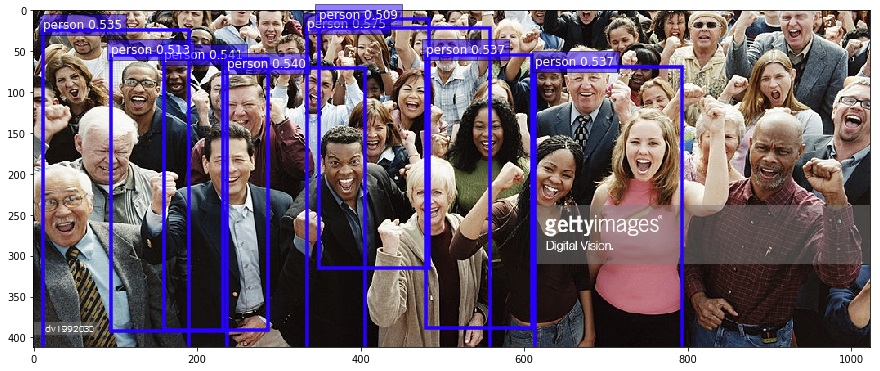

In [44]:
ax = viz.plot_bbox(img, bounding_boxs[0].astype(int), scores[0]*3,
                         class_IDs[0], class_names=net.classes)
plt.show()